<a href="https://colab.research.google.com/github/AhnJG/AI-Project/blob/master/Colab/text_classification_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 텍스트 분류 자습서 는 감정 분석을 위해 IMDB 대형 영화 검토 데이터 세트 에서 반복적 인 신경망을 학습시킵니다 .

### 설정

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  !pip install tf-nightly
except Exception:
  pass
import tensorflow_datasets as tfds
import tensorflow as tf

In [0]:
print(tf.__version__)

2.2.0-dev20200201


In [0]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

### 입력 파이프 라인 설정
IMDB 대형 영화 리뷰 데이터 세트는 이진 분류 데이터 세트입니다. 모든 리뷰에는 긍정적 또는 부정적 감정이 있습니다.

TFDS를 사용하여 데이터 세트를 다운로드하십시오 .

In [0]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

데이터 세트 info에는 인코더 (a tfds.features.text.SubwordTextEncoder)가 포함됩니다.

In [0]:
encoder = info.features['text'].encoder

In [0]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


이 텍스트 인코더는 문자열을 가역적으로 인코딩하여 필요한 경우 바이트 인코딩으로 돌아갑니다.

In [0]:
sample_string = 'Hello Tensorflow'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 2934]
The original string: "Hello Tensorflow"


In [0]:
assert original_string == sample_string

In [0]:
for index in encoded_string:
    print('{} ----> {}'.format(index, encoder.decode([index])))

4025 ----> Hell
222 ----> o 
6307 ----> Ten
2327 ----> sor
2934 ----> flow


### 훈련을위한 데이터 준비
그런 다음이 인코딩 된 문자열을 일괄 적으로 생성하십시오. 이 padded_batch방법을 사용하여 배치를 가장 긴 문자열 n의 길이로 시퀀스를 0으로 채 웁니다.

In [0]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [0]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

### 모델 만들기
tf.keras.Sequential모델을 구축하고 포함 레이어로 시작 하십시오 . 임베드 레이어는 단어 당 하나의 벡터를 저장합니다. 호출되면 단어 인덱스 시퀀스를 벡터 시퀀스로 변환합니다. 이 벡터는 훈련 가능합니다. (충분한 데이터에 대한) 훈련 후 유사한 의미를 가진 단어는 종종 비슷한 벡터를 갖습니다.

이 인덱스 조회는 one-hot 인코딩 된 벡터를 tf.keras.layers.Dense레이어 에 전달하는 동등한 작업보다 훨씬 효율적 입니다.

RNN (Recurrent Neural Network)은 요소를 반복하여 시퀀스 입력을 처리합니다. RNN은 출력을 한 단계에서 입력으로 전달한 다음 다음 단계로 전달합니다.

tf.keras.layers.Bidirectional랩퍼는 또한 RNN 층으로 사용될 수있다. 이는 RNN 계층을 통해 입력을 앞뒤로 전파 한 다음 출력을 연결합니다. 이는 RNN이 장거리 종속성을 학습하는 데 도움이됩니다.

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [0]:
test_dataset

<PaddedBatchDataset shapes: ((None, None), (None,)), types: (tf.int64, tf.int64)>

In [0]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 56s 142ms/step - loss: 0.6616 - accuracy: 0.5959 - val_loss: 0.5272 - val_accuracy: 0.7672
Epoch 2/10
391/391 [==============================] - 47s 120ms/step - loss: 0.3736 - accuracy: 0.8462 - val_loss: 0.3650 - val_accuracy: 0.8385
Epoch 3/10
391/391 [==============================] - 46s 118ms/step - loss: 0.2660 - accuracy: 0.9002 - val_loss: 0.3186 - val_accuracy: 0.8672
Epoch 4/10
391/391 [==============================] - 47s 121ms/step - loss: 0.2228 - accuracy: 0.9210 - val_loss: 0.3400 - val_accuracy: 0.8615
Epoch 5/10
391/391 [==============================] - 48s 122ms/step - loss: 0.1944 - accuracy: 0.9327 - val_loss: 0.3489 - val_accuracy: 0.8453
Epoch 6/10
391/391 [==============================] - 48s 122ms/step - loss: 0.1912 - accuracy: 0.9371 - val_loss: 0.3628 - val_accuracy: 0.8594
Epoch 7/10
391/391 [==============================] - 47s 121ms/step - loss: 0.1485 - accuracy: 0.9522 - val_loss: 0.3955 - val_ac

In [0]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

    391/Unknown - 19s 48ms/step - loss: 0.4453 - accuracy: 0.8579Test Loss: 0.44532628959554543
Test Accuracy: 0.8578799962997437


위의 모델은 시퀀스에 적용된 패딩을 가리지 않습니다. 패딩 된 시퀀스를 학습하고 패딩되지 않은 시퀀스를 테스트하면 왜곡 될 수 있습니다. 이상적으로는 이것을 피하기 위해 마스킹 을 사용 하지만 아래에서 볼 수 있듯이 출력에는 약간의 영향 만 미칩니다.

예측이> = 0.5 인 경우, 양수이고 그렇지 않으면 음수입니다.

In [0]:
def pad_to_size(vec, size):
    zeros = [0] * (size - len(vec))
    vec.extend(zeros)
    return vec

In [0]:
def sample_predict(sentence, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [0]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.44093394]]


In [0]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.4071148]]


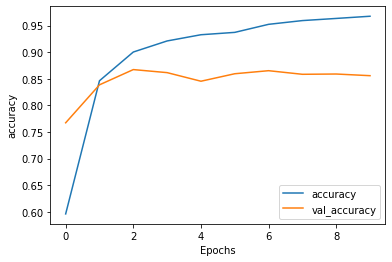

In [0]:
plot_graphs(history, 'accuracy')

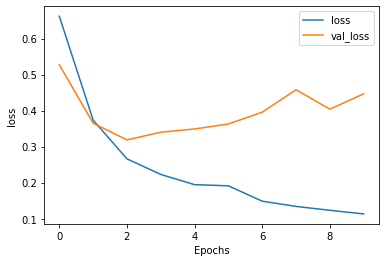

In [0]:
plot_graphs(history, 'loss')

### 두 개 이상의 LSTM 레이어 쌓기
Keras 반복 레이어에는 return_sequences생성자 인수 로 제어되는 두 가지 사용 가능한 모드가 있습니다 .

각 타임 스텝 (모양의 3D 텐서)에 대한 전체 연속 출력 시퀀스를 반환합니다 (batch_size, timesteps, output_features).
각 입력 시퀀스에 대한 마지막 출력 만 반환합니다 (형태의 2D 텐서 (batch_size, output_features)).

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [38]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30
                    )

Epoch 1/10
391/391 [==============================] - 83s 213ms/step - loss: 0.6784 - accuracy: 0.5512 - val_loss: 0.5458 - val_accuracy: 0.7437
Epoch 2/10
391/391 [==============================] - 78s 198ms/step - loss: 0.3822 - accuracy: 0.8457 - val_loss: 0.3295 - val_accuracy: 0.8651
Epoch 3/10
391/391 [==============================] - 75s 193ms/step - loss: 0.2626 - accuracy: 0.9068 - val_loss: 0.3195 - val_accuracy: 0.8677
Epoch 4/10
391/391 [==============================] - 77s 198ms/step - loss: 0.2120 - accuracy: 0.9296 - val_loss: 0.3282 - val_accuracy: 0.8786
Epoch 5/10
391/391 [==============================] - 78s 199ms/step - loss: 0.1858 - accuracy: 0.9405 - val_loss: 0.3519 - val_accuracy: 0.8604
Epoch 6/10
391/391 [==============================] - 76s 194ms/step - loss: 0.1511 - accuracy: 0.9554 - val_loss: 0.3881 - val_accuracy: 0.8661
Epoch 7/10
391/391 [==============================] - 77s 197ms/step - loss: 0.1289 - accuracy: 0.9653 - val_loss: 0.4389 - val_ac

In [39]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

    391/Unknown - 36s 92ms/step - loss: 0.5323 - accuracy: 0.8524Test Loss: 0.5323053742842296
Test Accuracy: 0.8523600101470947


In [40]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print (predictions)

[[0.0570222]]


In [41]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print (predictions)

[[0.01244796]]


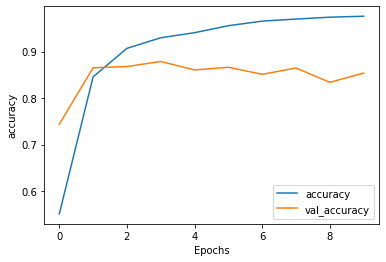

In [42]:
plot_graphs(history, 'accuracy')

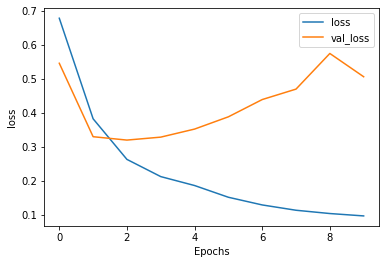

In [43]:
plot_graphs(history, 'loss')